In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)
        
import os
# Uncomment for CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import utils.probabilistic_drnn_model
import utils.visualization
import utils.tf_helpers
import utils.prefetch_generator
import h5py
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import threading
import dask.array as da

import sacred

tf.__version__

'2.1.0'

<KeysViewHDF5 ['actions', 'checkpoints', 'observations', 'rewards', 'track', 'track_len']>


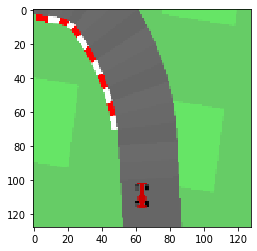

In [2]:
hd = h5py.File('../../DQN/car_racing.hdf5', 'r+')

MIN_REWARD = hd['rewards'][()].min()
MAX_REWARD = hd['rewards'][()].max()
MIN_REWARD, MAX_REWARD

observations = hd['observations']
observations = da.from_array(hd['observations'], chunks=(64, 1000, 16, 16, 3))
rewards = (hd['rewards'] - MIN_REWARD) / (MAX_REWARD - MIN_REWARD)
actions = hd['actions'][()]

print(hd.keys())

im = observations[0, 500]
plt.imshow(im / 255)

In [3]:
ex = sacred.Experiment(name='DRNN Car Racing 2 (big hdf5)', interactive=True)

In [4]:
# @ex.capture
# def make_dataset(bs, W, H, SEQ_LEN):
#     def data_input():
#         for a, o, r in zip(actions, observations, rewards):
#             a = a[:SEQ_LEN]r
#             o = o[:SEQ_LEN] / 255.0
#             r = r[:SEQ_LEN]

#             yield (a,), (o, r)

#     ds = tf.data.Dataset.from_generator(
#         data_input,
#         output_types=((tf.float32,), (tf.float32, tf.float32)),
#         # the output shapes is required because of - https://github.com/tensorflow/tensorflow/issues/24520
#         output_shapes=((tf.TensorShape((SEQ_LEN, 3)),), (tf.TensorShape((SEQ_LEN, W, H, 3)), tf.TensorShape((SEQ_LEN)))),
#     )

#     ds = ds.repeat()
#     ds = ds.map(lambda x,y : (x, y), num_parallel_calls=16)
# #     ds = ds.prefetch(16)

#     return ds

In [5]:
observations[:5, :512]

dask.array<getitem, shape=(5, 512, 128, 128, 3), dtype=float32, chunksize=(5, 512, 16, 16, 3), chunktype=numpy.ndarray>

In [6]:
@ex.capture
def make_dataset(batch_size, W, H, SEQ_LEN):
    chunk_size = 2
    @utils.prefetch_generator.prefetch(num_to_prefetch=64, max_workers=32)
    def chunks(i):
        l, r = i * chunk_size, i * chunk_size + chunk_size
        a = actions[l:r, :SEQ_LEN]
        o = observations[l:r, :SEQ_LEN].compute() / 255.0
        r = rewards[l:r, :SEQ_LEN]

        return a, o, r
    
    def dechunk():
        for a, o, r in chunks():
            for _a, _o, _r in zip(a, o, r):
                yield (_a,), (_o, _r)

    ds = tf.data.Dataset.from_generator(
        dechunk,
        output_types=((tf.float32,), (tf.float32, tf.float32)),
        # the output shapes is required because of - https://github.com/tensorflow/tensorflow/issues/24520
        output_shapes=((tf.TensorShape((SEQ_LEN, 3)),), (tf.TensorShape((SEQ_LEN, W, H, 3)), tf.TensorShape((SEQ_LEN)))),
    )
    ds = ds.batch(batch_size)

#     ds = ds.repeat()
#     ds = ds.map(lambda x,y : (x, y), num_parallel_calls=16)
#     ds = ds.prefetch(16)

    return ds

In [7]:
list(make_dataset(2, 128, 128, 512).take(1))[0][1][0].shape

TensorShape([2, 512, 128, 128, 3])

In [8]:
def on_batch_begin(model, input_generator):
    def sampler():
        X, Y = list(input_generator.take(1))[0]
        return X, Y[0]

    utils.visualization.plot_pairwise_frames(
        sampler=sampler,
        hypotheses=lambda x: model.net.predict(x)[0][0]
    )
    
    if 'loss' in model.net.history.history:
        loss = model.net.history.history['loss'][-1]
        ex.log_scalar('loss', loss)

    pred_rollout_name = 'pred_rollout.png'
    plt.savefig(pred_rollout_name)
    ex.add_artifact(pred_rollout_name)
    plt.show()

In [9]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
    batch_size,
    steps_per_epoch,
    lr,
    weight_decay,
    should_preload_model,
):
    input_generator = make_dataset()

    #### Model
    model = utils.probabilistic_drnn_model.DRNN(internal_size=internal_size, W=W, H=H, lr=lr, weight_decay=weight_decay)
    model.net.summary()

    model_img_name = 'model.png'
    tf.keras.utils.plot_model(model.net, to_file=model_img_name, show_shapes=True, expand_nested=False, rankdir='TB', dpi=90)
    ex.add_artifact(model_img_name)
    
    #### Callbacks
    callbacks = [
        utils.tf_helpers.model_persistor(
            model,
            should_preload_model=should_preload_model,
            cp_file_name='cp-drnn-{epoch:0004d}-{loss:.5f}.hdf5'
        ),
        utils.tf_helpers.on_batch_begin(lambda: on_batch_begin(model, input_generator)),
        model.tb_callback,
    ]
    
    #### Training
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=steps_per_epoch,
        epochs=2000,
        callbacks=callbacks
    )

In [10]:
@ex.config
def config():
    SEQ_LEN = 256
    W, H = 128, 128
    internal_size = 32
    batch_size = 8
    steps_per_epoch = 128
    lr = 0.001
    weight_decay = 0.0001
    should_preload_model = True

WARNING - DRNN Car Racing 2 (big hdf5) - No observers have been added to this run
INFO - DRNN Car Racing 2 (big hdf5) - Running command 'main'
INFO - DRNN Car Racing 2 (big hdf5) - Started


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
action (InputLayer)             [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
rnn_gru_gru1 (GRU)              (None, None, 32)     3552        action[0][0]                     
__________________________________________________________________________________________________
batch_norm_gru1 (BatchNormaliza (None, None, 32)     128         rnn_gru_gru1[0][0]               
__________________________________________________________________________________________________
space_to_batch_gru2 (Lambda)    (None, None, 32)     0           batch_norm_gru1[0][0]            
______________________________________________________________________________________________

WARNING - tensorflow - From <ipython-input-9-70dead8da47f>:40: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Train for 128 steps, validate for 2 steps


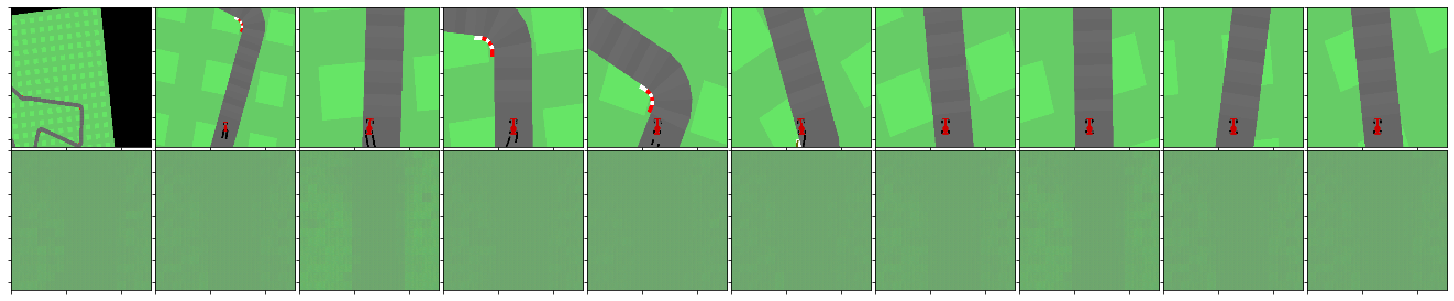

Epoch 1/2000
128/128 [==============================] - 515s 4s/step - loss: 1.0402 - time_distributed_2_loss: 0.6436 - reward_dense2_loss: 0.3966 - val_loss: 0.9726 - val_time_distributed_2_loss: 0.6422 - val_reward_dense2_loss: 0.3303


In [ ]:
# ex.observers.append(sacred.observers.MongoObserver())
ex.run(config_updates={'should_preload_model': True})